# Imports

In [63]:
import os
import torch
os.environ['TORCH'] = torch.__version__

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import networkx as nx

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import networkx as nx
from functools import reduce

from tqdm import tqdm

import primefac

# Utility

In [65]:
# code based on: https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning
def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None,
                   special_color=False, pos=None):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    if layout == 'custom':
      node_pos = pos
    elif layout == 'tree':
      node_pos=nx.nx_agraph.graphviz_layout(graph, prog='dot')
    else:
      node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

# code based on: https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning
def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color,
                            pos=graphs[i].pos)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

# Cayley

In [66]:
from collections import deque
from primefac import primefac

def get_minimal_n_cayley_graph(num_nodes):
    n = get_cayley_n(num_nodes)
    return get_cayley_graph(n)


# Simple code to generate a Cayley graph
def get_cayley_graph(n): 
    """
        Get the edge index of the Cayley graph (Cay(SL(2, Z_n); S_n)).
    """
    generators = np.array([
        [[1, 1], [0, 1]],
        [[1, n-1], [0, 1]],
        [[1, 0], [1, 1]],
        [[1, 0], [n-1, 1]]
    ])
    ind = 1

    queue = deque([np.array([[1, 0], [0, 1]])])
    nodes = {(1, 0, 0, 1): 0}

    senders = []
    receivers = []

    while queue:
        x = queue.pop()
        x_flat = (x[0][0], x[0][1], x[1][0], x[1][1])
        assert x_flat in nodes
        ind_x = nodes[x_flat]
        for i in range(4):
            tx = np.matmul(x, generators[i])
            tx = np.mod(tx, n)
            tx_flat = (tx[0][0], tx[0][1], tx[1][0], tx[1][1])
            if tx_flat not in nodes:
                nodes[tx_flat] = ind
                ind += 1
                queue.append(tx)
            ind_tx = nodes[tx_flat]

            senders.append(ind_x)
            receivers.append(ind_tx)
    return torch.tensor([senders, receivers])


def get_cayley_n(num_nodes):
    n = 1
    while cayley_graph_size(n) < num_nodes:
        n += 1
    return n


def cayley_graph_size(n):
    n = int(n)
    return round(n*n*n*np.prod([1 - 1.0/(p * p) for p in list(set(primefac(n)))]))


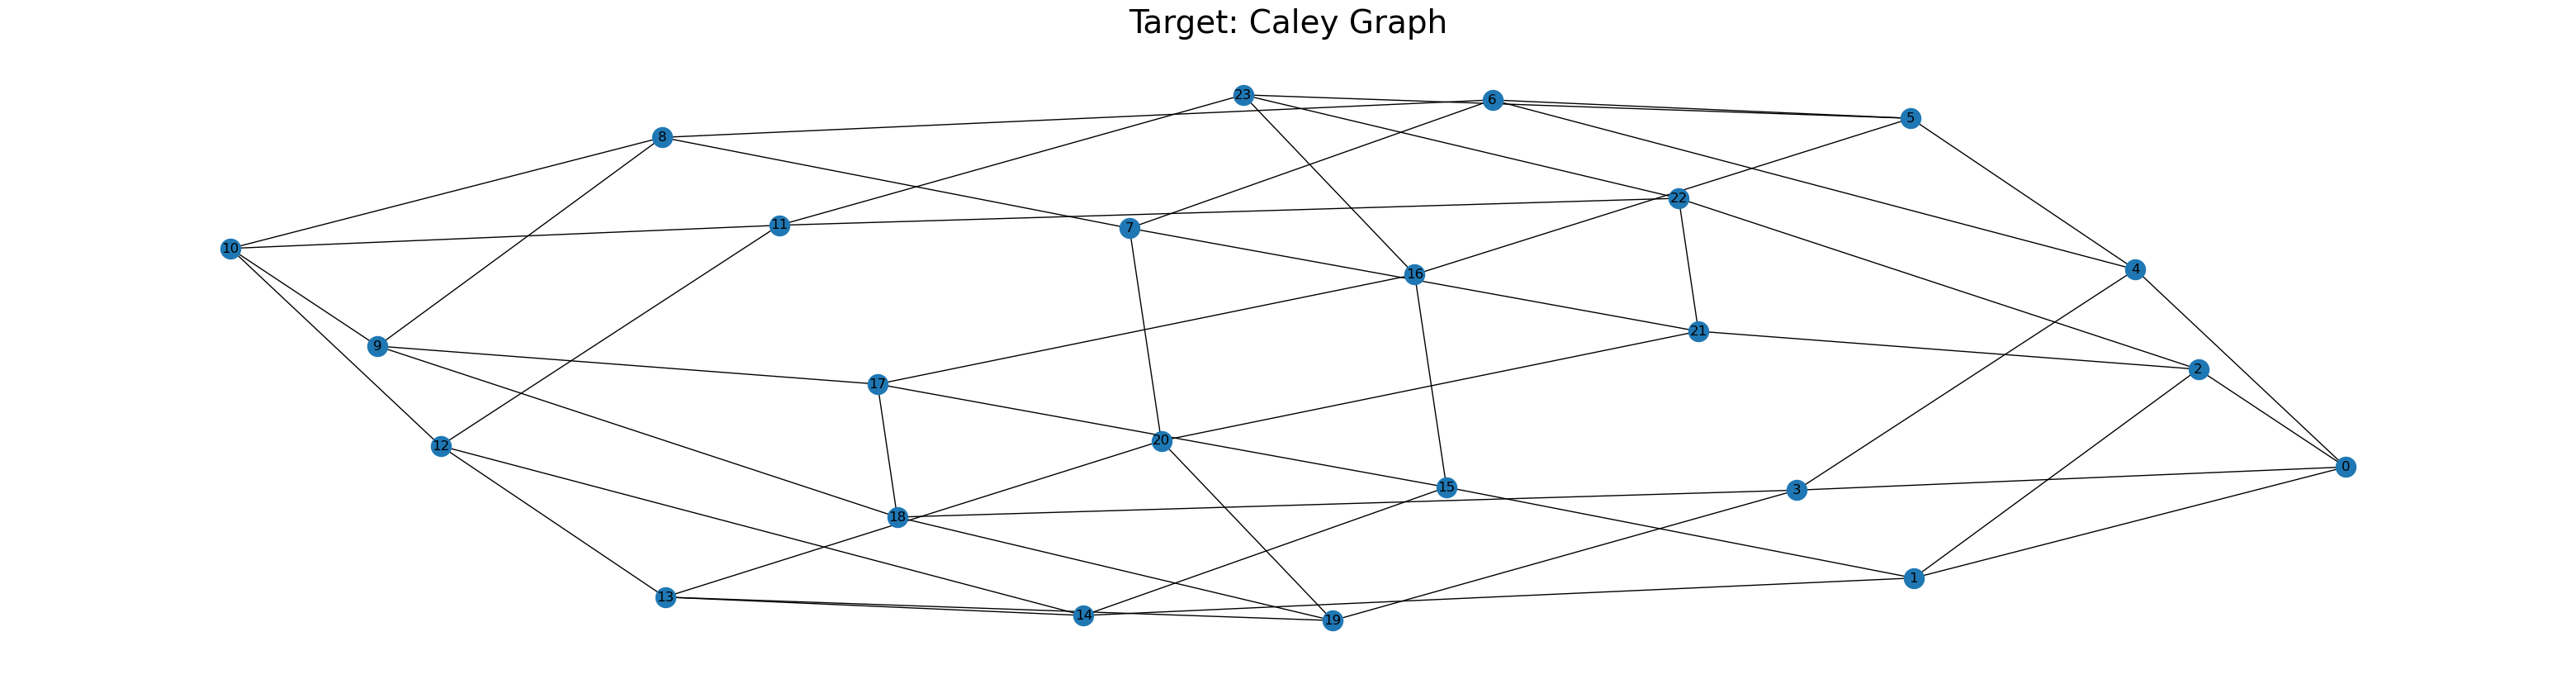

In [67]:
cayley_graph = Data(edge_index=get_minimal_n_cayley_graph(8))
gallery([cayley_graph], ['Caley Graph'])

In [ ]:
def build_cayley_graph(	text_embeds: torch.Tensor,
						image_embeds: torch.Tensor,
						attn_mask: torch.Tensor,
						):
	if text_embeds.shape[0] != attn_mask.shape[0]:
		raise ValueError("text_embeds and attn_mask must have same batch size")
    
	res = []
	# For each sample in batch, build Cayley Graph with embeddings.
	for i in range(text_embeds.shape[0]):
		text_emb = text_embeds[i][attn_mask[i].bool()]
		img_emb = image_embeds[i]

		feats = torch.cat([text_emb, img_emb], dim=0)

		n_nodes = feats.shape[0]

		cayley_graph = get_minimal_n_cayley_graph(n_nodes)
		print(cayley_graph)
		num_virts = cayley_graph_size(get_cayley_n(n_nodes)) - n_nodes

		virt_feats = torch.zeros((num_virts, text_emb.shape[1]), device=text_embeds.device)

		res.append(
			Data(x=torch.cat([feats, virt_feats], dim=0), edge_index=cayley_graph)
		)
	
	return res
	

In [81]:
# from add_graphs_to_vqa import embed_text, embed_image, data_to_dict

# def process_batch(batch):
# 	questions = batch['question']
# 	image_ids = batch['image_id']

# 	# Embed question
# 	q_embs, attn_mask = embed_text(questions)

# 	# dedup while keeping map
# 	id2img = {}
# 	for idx, img_id in enumerate(image_ids):
# 		if img_id not in id2img:
# 			id2img[img_id] = batch['image'][idx].convert("RGB")

# 	unique_embeds = embed_image(list(id2img.values()))

# 	id_to_emb = {k: v for k, v in zip(id2img.keys(), unique_embeds)}
# 	i_embs = torch.stack([id_to_emb[img_id] for img_id in image_ids])

# 	# Build multimodal graphs
# 	graphs = build_cayley_graph(text_embeds=q_embs,
# 									image_embeds=i_embs,
# 									attn_mask=attn_mask,
# 	)

# 	batch['multimodal_graph'] = [data_to_dict(graph) for graph in graphs]

# 	return batch

In [82]:
import warnings, torch, requests, matplotlib.pyplot as plt, networkx as nx
warnings.filterwarnings("ignore")

from transformers import BeitImageProcessor, BeitModel, BertTokenizer, BertModel
from torch_geometric.utils import to_networkx
from PIL import Image

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


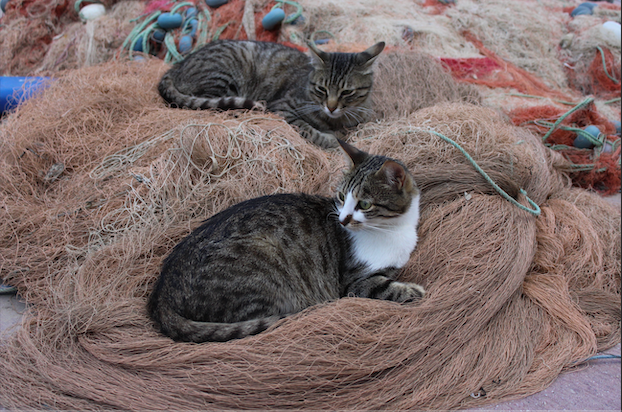

In [91]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")


model_name = "microsoft/beit-base-patch16-224"
beit_processor = BeitImageProcessor.from_pretrained(model_name)
beit = BeitModel.from_pretrained(model_name, use_safetensors=True)


# text = ["BERT is great for natural language processing!"]
text = ["BERT is great for natural language processing!", "Hi my name is Danik.", "Lorem ipsum dolor sit amet consectetur adipiscing elit quisque faucibus ex sapien vitae pellentesque sem placerat in id cursus mi pretium tellus duis convallis tempus leo eu aenean sed diam urna tempor pulvinar vivamus fringilla lacus nec metus bibendum egestas iaculis massa nisl malesuada lacinia integer nunc posuere ut hendrerit semper vel class aptent taciti sociosqu ad litora torquent per conubia nostra inceptos himenaeos orci varius natoque penatibus et magnis dis parturient montes nascetur ridiculus mus donec rhoncus eros lobortis nulla molestie mattis scelerisque maximus eget fermentum odio phasellus non purus est efficitur laoreet mauris pharetra vestibulum fusce dictum risus."]

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image

In [92]:
text_inputs = bert_tokenizer(text, return_tensors="pt", padding=True)
print(f'{text_inputs=}')

# Forward pass (no gradient calculation needed for inference)
with torch.no_grad():
    outputs = bert(**text_inputs)

# Extract embeddings
text_embeds = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]

print(f'{text_embeds.shape=}')

text_inputs={'input_ids': tensor([[  101, 14324,  2003,  2307,  2005,  3019,  2653,  6364,   999,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,    

In [93]:
img_inputs = beit_processor(images=[image]*3, return_tensors="pt")
print(f'{img_inputs["pixel_values"].shape=}')

with torch.no_grad():
    outputs = beit(**img_inputs, output_hidden_states=True)

# outputs.last_hidden_state → [batch_size, num_patches+1, hidden_dim]
# The first token is [CLS], the rest are patch embeddings
last_hidden = outputs.last_hidden_state

img_embeds = last_hidden[:, 1:, :]  # contextualized patch embeddings
print(f"Patches shape: {img_embeds.shape}")  # (1, num_patches, hidden_dim)


img_inputs["pixel_values"].shape=torch.Size([3, 3, 224, 224])
Patches shape: torch.Size([3, 196, 768])


In [94]:
res = build_cayley_graph(
    text_embeds=text_embeds,
    image_embeds=img_embeds,
    attn_mask=text_inputs['attention_mask'],
)

res

text_emb.shape=torch.Size([10, 768])
tensor([[ 0,  0,  0,  ...,  1,  1,  1],
        [ 1,  2,  3,  ...,  0, 64, 54]])
text_emb.shape=torch.Size([9, 768])
tensor([[ 0,  0,  0,  ...,  1,  1,  1],
        [ 1,  2,  3,  ...,  0, 64, 54]])
text_emb.shape=torch.Size([233, 768])
tensor([[ 0,  0,  0,  ...,  1,  1,  1],
        [ 1,  2,  3,  ...,  0, 88, 72]])


[Data(x=[336, 768], edge_index=[2, 1344]),
 Data(x=[336, 768], edge_index=[2, 1344]),
 Data(x=[648, 768], edge_index=[2, 2592])]

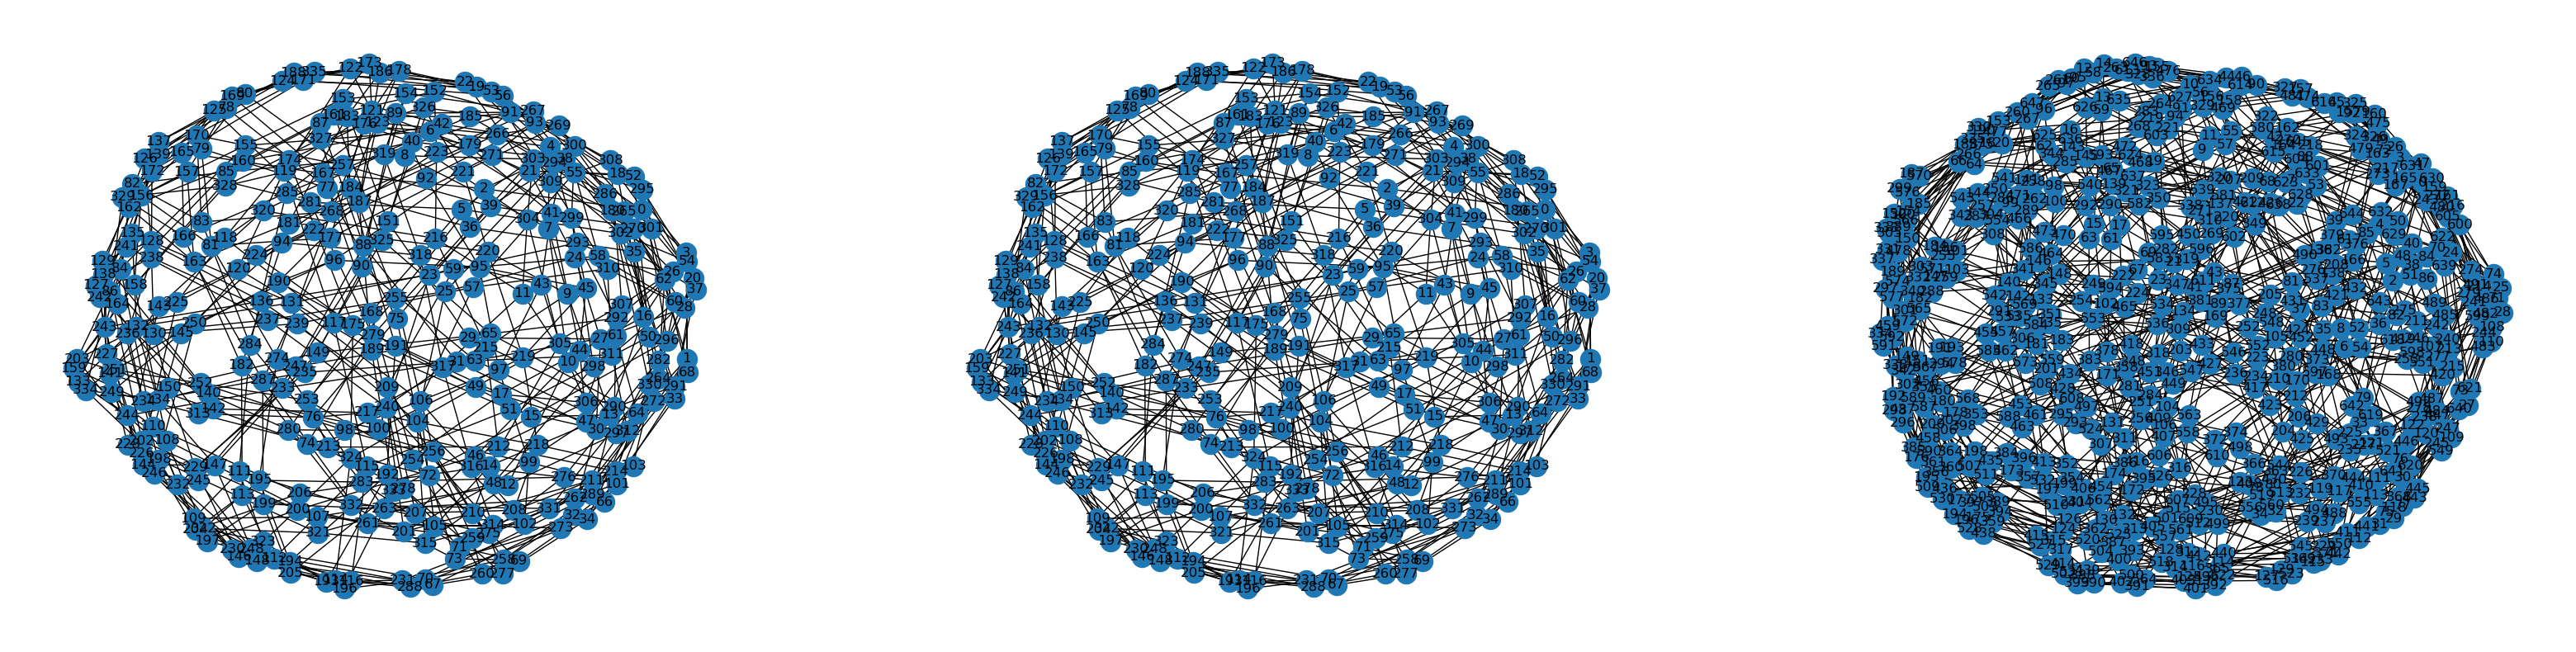

In [95]:
gallery(res)

## Dataset Transformation